In [1]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from pyro import plate
import matplotlib.pyplot as plt


from torch import nn
class SVI_recommender(nn.Module):
    def __init__(self, U, V):
        super(SVI_recommender, self).__init__()
        self.U = U
        self.V = V

    def predict(self, user_ids, item_ids):
        uservec = self.U[user_ids]
        itemvec = self.V[item_ids]
        preds = (uservec * itemvec).sum(1)
        return preds.numpy()
d = 5

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 100000
num users: 944, num items: 1683


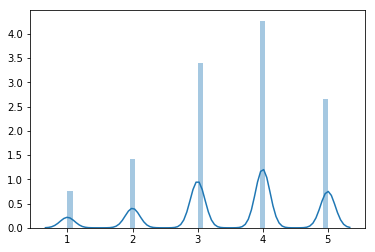

In [2]:
ds = get_movielens_dataset(variant='100K')

items = pd.read_csv("movies.dat", delimiter="::", header=None, engine = "python")
items.columns = ['itemId', 'name','genre']
ind2item = {row.itemId : row.name for row in items.itertuples()}

train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")

## pyro implementation

In [3]:
pyro.clear_param_store()
def model(dat):
    mu0 = torch.zeros(d)
    var0 = torch.diag(torch.ones(d))*0.2

    muU = pyro.sample("muU", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
    muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
    varU = varV = var0
    obsvar = pyro.sample("obsvar", dist.Exponential(rate= 10.0))
    
    with plate("user_loop", dat.num_users) as i:
        U = pyro.sample(f"u_", dist.MultivariateNormal(muU, varU))
        
    with plate("item_loop", dat.num_items) as i:
        V = pyro.sample(f"i_", dist.MultivariateNormal(muV, varV))
    
    
    with plate("data_loop", size = len(dat.ratings)) as k:
        u = U[dat.user_ids[k]]
        v = V[dat.item_ids[k]]
        score = u.mul(v).sum(1)
        r = torch.tensor(dat.ratings[k])
        pyro.sample(f"obs", dist.Normal(loc = score, scale = 1.0), obs=r)

In [4]:
def guide(dat):
    obsvar_rate = pyro.param("obsvar_rate", torch.tensor(10.0), constraint = constraints.positive)
    obsvar = pyro.sample("obsvar", dist.Exponential(obsvar_rate))
    
    varU = pyro.param("varU", torch.ones(d), constraint = constraints.positive)
    covarU = torch.diag(varU)
    varV = pyro.param("varV", torch.ones(d), constraint = constraints.positive)
    covarV = torch.diag(varV)
    
    muUpar = pyro.param("muUpar", torch.rand(d)-0.5)
    muVpar = pyro.param("muVpar", torch.rand(d)-0.5)

    # Global vars:
    muU = pyro.sample("muU", dist.MultivariateNormal(loc = muUpar, covariance_matrix= covarU))
    muV = pyro.sample("muV", dist.MultivariateNormal(loc = muVpar, covariance_matrix= covarV))

    ## user latent vectors
    U = pyro.param("user_mat", torch.rand(dat.num_items, d)-0.5)
    V = pyro.param("item_mat", torch.rand(dat.num_items, d)-0.5)

    with plate("user_loop", dat.num_users) as i:
        U = pyro.sample(f"u_", dist.MultivariateNormal(U[i,], covarU))
        

    ## item latent vectors
    with plate("item_loop", dat.num_items) as i:
        U = pyro.sample(f"i_", dist.MultivariateNormal(V[i,], covarV))



In [5]:
%%time
n_steps = 500
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi.step(train)

# do gradient steps
for step in range(n_steps):
    loss = svi.step(train)

    if step%10== 0:
        # RMSE
        svimodel = SVI_recommender(U = pyro.param("user_mat").detach(), 
                   V = pyro.param("item_mat").detach())
        rmse_test = rmse_score(svimodel, test)
        print(f"step: {step} \t loss: {loss:.0f} \t test-rmse: {rmse_test:.2f}")

step: 0 	 loss: 888351 	 test-rmse: 3.70
step: 10 	 loss: 722021 	 test-rmse: 3.70
step: 20 	 loss: 667124 	 test-rmse: 3.67
step: 30 	 loss: 591683 	 test-rmse: 3.42
step: 40 	 loss: 339908 	 test-rmse: 2.12
step: 50 	 loss: 223459 	 test-rmse: 1.20
step: 60 	 loss: 173546 	 test-rmse: 1.03
step: 70 	 loss: 168148 	 test-rmse: 1.11
step: 80 	 loss: 150370 	 test-rmse: 0.99
step: 90 	 loss: 141328 	 test-rmse: 0.98
step: 100 	 loss: 135888 	 test-rmse: 0.98
step: 110 	 loss: 132743 	 test-rmse: 0.98
step: 120 	 loss: 131327 	 test-rmse: 0.97
step: 130 	 loss: 132299 	 test-rmse: 0.97
step: 140 	 loss: 129682 	 test-rmse: 0.97
step: 150 	 loss: 128180 	 test-rmse: 0.96
step: 160 	 loss: 125140 	 test-rmse: 0.96
step: 170 	 loss: 125685 	 test-rmse: 0.96
step: 180 	 loss: 123702 	 test-rmse: 0.96
step: 190 	 loss: 124601 	 test-rmse: 0.96
step: 200 	 loss: 124216 	 test-rmse: 0.96
step: 210 	 loss: 124529 	 test-rmse: 0.95
step: 220 	 loss: 121613 	 test-rmse: 0.95
step: 230 	 loss: 1214